# Install

We create "qiime2-amplicon-2025.7" environment and install `qiime2` Amplicon plugins (see https://library.qiime2.org/quickstart). It contains the command line tools we need to do taxanomy classification. Also install `redbiom` to download data from Qiita. 

Run the following in terminal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from biom import load_table
from statsmodels.distributions.empirical_distribution import ECDF
import biom
import h5py
import polars as pl
from datetime import datetime
import os

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

# Download AGP data from Qiita database via `redbiom`

Qiita (https://qiita.ucsd.edu) is an open-source microbial study management platform. To retrieve data from Qiita, we need `redbiom` command line tool (https://qiita.ucsd.edu/static/doc/html/reanalysis/reanalysis.html). `download.sh` is a summry of the following steps and can be directly submitted in terminal. 

## Set context

In Qiita, study data is grouped into contexts representing different processing pipelines. The general syntax of the context is `<binning strateg>-<reference database>-<sequencing strategy>-<region sequenced>-<(if trimmed) trimming length>-<id>`. There are 332 contexts in total at the time of this writing.

In order to download any study data, we must first specify its contexts. However, note that the contexts cannot serve as a unique identification key to search study data---one context can correspond to multiple studies, and one study can have multiple contexts. Worse still, the contexts are sometimes updated and encoded in a sloppy way. There is no easy way to accurately find the context(s) corresponding to a study. We just use the context that corresponds to enough samples and ASV features.

In [2]:
%%skip
contexts=pd.read_csv("~/data/raw/contexts.txt", sep="\t", header=0)
contexts.sort_values(by="SamplesWithData", ascending=False).head(10)

## Download sample ids

- The study id of AGP is 10317.
-`grep -vi "blank"` means to exclude any lines containing `"blank"`, ignoring the case. In this way we only retrieve ID'd (non-blank) samples.
- AGP contains 35,988 non-blank sample ids. We will use a random subsample of the full data. `shuf -n <number>` means shuffles the lines piped to it and randomly selects `<number>` lines.
- `redbiom summarize samples` gives a summary of sample types of the selected samples. One can use `--categories <keyword>` for other keyword.

## Download the abundance data of the selected samples (raw integer count)

- Note that the number of samples that are retrieved in the abundance data might be fewer than the number of samples randomly selected in `AGP-samples.txt`, due to the filtering by context.

In [3]:
%%skip
abundance_table = load_table("/home/jupyter/data/raw/AGP.rawASV.biom")
print(abundance_table.head(3))

# Check if the abundance data are all integer count
abundance_array = abundance_table.to_dataframe().values[:1000, :1000]
print("\nRaw integer count?", (abundance_array == abundance_array.astype(int)).all())
del(abundance_array)

## Download the metadata of the selected samples

# Match the sample ids in abundance table and metadata

*This step should be done after downloading the raw data before ASV classification.*

- The format of the sample ids in the abundance table does not match that in the metadata. We need to modify the format.
- In addition to the format, there is also some other mismatch between the samples in the abundance table and the samples in the metadata. We take their intersection.
- There are duplicate sample ids in the abundance table. We remove duplicate ids.

In [4]:
%%skip
abundance_table = load_table('/home/jupyter/data-full/AGP.rawASV.biom')
metadata = pd.read_csv('/home/jupyter/data-full/AGP.metadata.raw.tsv', sep="\t", header = 0)
print(f'abundance_table raw shape: {abundance_table.shape}\nmetadata raw shape: {metadata.shape}')
metadata.head(3)

abundance_table raw shape: (533309, 31603)
metadata raw shape: (35988, 146)


,#SampleID,milk_cheese_frequency,drinking_water_source,artificial_sweeteners,host_weight,lung_disease,host_height_units,specialized_diet_exclude_dairy,sugary_sweets_frequency,exercise_frequency,...,thyroid,skin_condition,race,non_food_allergies_unspecified,specialized_diet_exclude_refined_sugars,host_weight_units,acid_reflux,public,ibd,epilepsy_or_seizure_disorder
0,10317.0363157978,Regularly (3-5 times/week),not provided,Never,49.89522003792037,I do not have this condition,cm,false,Daily,Regularly (3-5 times/week),...,I do not have this condition,not provided,not provided,false,false,kg,not provided,TRUE,I do not have this condition,I do not have this condition
1,10317.000002296,not provided,Filtered,not provided,51.0,not provided,cm,false,not provided,Regularly (3-5 times/week),...,not provided,I do not have this condition,Caucasian,true,false,kg,not provided,TRUE,I do not have this condition,not provided
2,10317.000089240,Rarely (less than once/week),Well,Daily,74.84283005688056,I do not have this condition,cm,false,Rarely (less than once/week),Occasionally (1-2 times/week),...,I do not have this condition,"Diagnosed by a medical professional (doctor, p...",Caucasian,true,false,kg,Self-diagnosed,TRUE,I do not have this condition,I do not have this condition


In [5]:
%%skip
# Select the sample ids in both metadata and abundance table
sample_ids_metadata = metadata['#SampleID'].values
sample_ids_abundance = abundance_table.ids(axis="sample")
keep_old_name = [] # the sample ids to keep
keep_new_name = [] # update the sample ids that are kept
for id_meta in sample_ids_metadata:
  for id_abund in sample_ids_abundance:
    if id_abund.startswith(id_meta): # intersection
      keep_old_name.append(id_abund)
      keep_new_name.append(id_meta)
      break
abundance_table.filter(keep_old_name, axis="sample", inplace=True)
# Update the sample ids in the abundance table
id_map = dict(zip(keep_old_name, keep_new_name))
abundance_table.update_ids(id_map, axis="sample", inplace=True)

del(sample_ids_metadata, sample_ids_abundance, keep_old_name, keep_new_name, id_map)
print(f'abundance_table current shape: {abundance_table.shape}')

# Take the intersection part in the metadata
metadata=metadata[metadata["#SampleID"].isin(abundance_table.ids(axis="sample"))]
print(f'metadata current shape: {metadata.shape}')

abundance_table current shape: (533309, 29290)
metadata current shape: (29290, 146)


In [6]:
%%skip
output_path = '/home/jupyter/data/matched/AGP.matchedASV.biom'
with h5py.File(output_path, 'w') as f:
    abundance_table.to_hdf5(f, "AGP abundance table")

file_path = '/home/jupyter/data/matched/AGP.metadata.matched.tsv'
metadata.to_csv(file_path, sep='\t', index=False, encoding='utf-8')

In [7]:
%%skip
del(output_path, file_path, abundance_table, metadata)

# Classify the ASV features using pre-trained classifier

*This section should be run after `classification.sh`.*

After running `classification.sh`, we merge the taxonomy information into the abundance table and save the entire table to `AGP.taxonomyASV.parquet`. 

In [2]:
abundance_table = load_table('/home/jupyter/data/matched/AGP.matchedASV.biom').to_dataframe(dense=True)
tax_table = pd.read_csv('/home/jupyter/data/classification/exported-taxonomy/taxonomy.tsv', sep='\t', index_col=0)
print(f'abundance table shape: {abundance_table.shape}\ntaxonomy table shape: {tax_table.shape}')
abundance_table.index.name = 'asv_id'

abundance table shape: (533309, 29290)
taxonomy table shape: (533309, 2)


In [3]:
# Split by ';'
tax_split = tax_table['Taxon'].str.split(';', expand=True)
# Remove prefix like 'd__', 'p__'
for col in tax_split.columns:
    tax_split[col] = tax_split[col].str.strip().str.replace(r'^[dpcofgs]__', '', regex=True).astype('category')
# Set column names
tax_split.columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
tax_split.index.name = 'asv_id'

In [4]:
# Merge abundance table with taxonomy
start_time = datetime.now()
tax_split_pl = pl.from_pandas(tax_split.reset_index())
abundance_table_pl = pl.from_pandas(abundance_table.reset_index())
end_time = datetime.now()
print(f"Format conversion took: {(end_time - start_time).seconds/60:.2f} minutes")
del(abundance_table, tax_split)

Format conversion took: 8.80 minutes


In [5]:
start_time = datetime.now()
abundance_tax_pl = tax_split_pl.join(abundance_table_pl, on='asv_id', how='inner')
end_time = datetime.now()
print(f"Merging abundance table with taxonomy took: {(end_time - start_time).seconds:.2f} seconds")

Merging abundance table with taxonomy took: 3.00 seconds


In [6]:
# Replace empty string "" in taxonomy with None
abundance_tax_pl = abundance_tax_pl.with_columns([
    pl.when(pl.col(c) == "") # condition：if the column value is ""
    .then(None)              # then：replace with None
    .otherwise(pl.col(c))    # otherwise：keep the original value
    .alias(c)                # apply the results back to the original column
    for c in ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
])

In [7]:
print(abundance_tax_pl.head(3))

shape: (3, 29_298)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ asv_id    ┆ Domain   ┆ Phylum    ┆ Class     ┆ … ┆ 10317.000 ┆ 10317.000 ┆ 10317.000 ┆ 10317.000 │
│ ---       ┆ ---      ┆ ---       ┆ ---       ┆   ┆ 101088    ┆ 066696    ┆ 084458    ┆ 073407    │
│ str       ┆ cat      ┆ cat       ┆ cat       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆          ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ TACGGAGGG ┆ Bacteria ┆ null      ┆ null      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ TGCAAGCGT ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ TATCCGGAA ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ TCA…      ┆          ┆           ┆           ┆   ┆           ┆        

In [11]:
agg_data_dir = '/home/jupyter/data/aggregation'
os.makedirs(agg_data_dir, exist_ok=True)
file_path = os.path.join(agg_data_dir, 'AGP.taxonomyASV.parquet')
abundance_tax_pl.write_parquet(file_path, compression='zstd')
print(f"DataFrame successfully saved to: {file_path}")

DataFrame successfully saved to: /home/jupyter/data/aggregation/AGP.taxonomyASV.parquet


# Aggregate abundance count by taxanomic levels

We aggregate the abundance count by different taxanomic levels `['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']`. Note that the data does not have non-null value for "Species" level. So we exclude "Species" from consideration.

In [2]:
file_path = '/home/jupyter/data/aggregation/AGP.taxonomyASV.parquet'
abundance_tax_pl = pl.read_parquet(file_path)

In [3]:
taxonomic_levels = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
sample_columns = abundance_tax_pl.columns[8:]

output_dir = '/home/jupyter/data/aggregation/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created folder: {output_dir}")

for level in taxonomic_levels:
    print(f"------------------ Aggregating {level} ------------------")
    aggregated_df = (
        abundance_tax_pl
        .filter(pl.col(level).is_not_null()) # Drop null rows in the current level
        .group_by(level)
        .agg(pl.sum(sample_columns))
        .sort(level)
    )
    
    output_filename = os.path.join(output_dir, f"aggASV_{level}.tsv")
    aggregated_df.write_csv(output_filename, separator='\t')

print("All files successfully saved!")

------------------ Aggregating Domain ------------------
------------------ Aggregating Phylum ------------------
------------------ Aggregating Class ------------------
------------------ Aggregating Order ------------------
------------------ Aggregating Family ------------------
------------------ Aggregating Genus ------------------
All files successfully saved!


# Stacked bar plot by taxonomic levels (to be removed)

In [65]:
def prepare_plot_dataframe(tax_level:str, n_taxa:int=5, n_subset:int=1000, seed:int=123) -> pl.dataframe.frame.DataFrame:
    """Get the dataframe corresponding to the required taxonomic level, 
    and prepare the dataframe for making the plot.
    
    Args:
        tax_level: One of ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus'].
        n_taxa: Plot the n_taxa most abundant taxa. Other taxa are grouped as 'Other'.
        n_subset: Randomly subset the data and take n_subset samples. The full data is too huge to be plotted.
        seed: The random seed to randomly subset the data.
    
    Returns:
        Returns a polar dataframe where the first column is the sample_id, 
        and the rest of the columns are the relative abundance of different taxa in this taxonomic level.
        Sample ids are sorted according to their relative abundance in the most abundant taxa.
    """
    
    # Extract aggregated data
    file_path = os.path.join('/home/jupyter/data-full/aggASV/', f"aggASV_{tax_level}.tsv")
    df = pl.read_csv(file_path, separator='\t')

    # Pivot the data longer and compute the relative abundance for each sample
    df_long = df.unpivot(index=tax_level, variable_name='sample_id', value_name='abundance')
    df_rel_abun = df_long.with_columns(
        (pl.col('abundance') * 100 / pl.col('abundance').sum().over('sample_id')).alias('relative_abundance')
    )
    df_rel_abun = df_rel_abun.with_columns(
        # Taxonomic categories with one sample with zero count have relative abundance NaN. Replace with 0
        pl.col('relative_abundance').fill_nan(0)
    )


    # Compute the mean of relative abundance for each taxa across samples
    df_means = df_rel_abun.group_by(tax_level).agg(
        pl.mean('relative_abundance').alias('mean_abundance')
    )

    # Only plot taxa with the top several highest average relative abundance. Group others as 'Other'
    top_k = min(len(set(df_means[tax_level])), n_taxa)
    abundance_threshold = sorted(df_means['mean_abundance'].to_list(), reverse=True)[top_k-1]
    abundant_groups = df_means.filter(pl.col('mean_abundance') >= abundance_threshold)[tax_level]

    df_processed = df_rel_abun.with_columns(
        pl.when(pl.col(tax_level).is_in(abundant_groups))
        .then(pl.col(tax_level))
        .otherwise(pl.lit('Other'))
        .alias(tax_level)
    ).group_by(['sample_id', tax_level]).agg( # aggregate the relative abundance for "Other"
        pl.sum('relative_abundance')
    )

    # Pivot wider
    df_plot = df_processed.pivot(index='sample_id', on=tax_level, values='relative_abundance').fill_null(0)

    # Sort columns to have a consistent plotting order
    cols = sorted([col for col in df_plot.columns if col not in ['sample_id', 'Other']])
    if 'Other' in df_plot.columns:
        df_plot = df_plot.select(['sample_id'] + cols + ['Other'])
    else:
        df_plot = df_plot.select(['sample_id'] + cols)


    # Randomly subset the data for plot
    df_plot = df_plot.sample(n=n_subset, seed=seed)
    
    # Sort the sample ids according to their relative abundance in the most abundant taxa
    taxa_cols = df_plot.columns[1:]
    tax_cols_sums = df_plot[:,1:].to_numpy().sum(axis=0)
    sort_by = taxa_cols[np.argmax(tax_cols_sums)] # most abundant taxa
    df_plot_sorted = df_plot.sort(sort_by, descending=True)
    
    return df_plot_sorted

def make_stacked_bar_plot(tax_level:str, df_plot_sorted:pl.dataframe.frame.DataFrame):
    """Make stacked bar plot for the given taxanomic level"""
    plot_path = os.path.join('/home/jupyter/data-full/aggASV/', f"stacked_{tax_level}.png")

    taxa_cols = df_plot_sorted.columns[1:]
    x = np.arange(len(df_plot_sorted)) # position of x-axis

    fig, ax = plt.subplots(figsize=(15,5))
    bottom = np.zeros(len(df_plot_sorted)) # track the bottom of bars
    colors = plt.cm.RdYlBu(np.linspace(0, 1, len(taxa_cols)))

    for i, taxon in enumerate(taxa_cols):
        values = df_plot_sorted[taxon].to_numpy()
        ax.bar(x, values, bottom=bottom, label=taxon, width=1.0, color=colors[i])
        bottom += values

    tick_interval = 200 # adjust the interval based on the sample size
    tick_locs = np.arange(0, len(df_plot_sorted) + 1, tick_interval)
    tick_labels = [str(loc) for loc in tick_locs]
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels)

    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Proportion', fontsize=12)
    ax.set_title('Relative Abundance ', fontsize=13)
    ax.legend(title=f'Taxonomic Levels [{tax_level}]', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.savefig(plot_path, dpi=300)
    plt.show()

## By Domain

There are 4 domains in total. Almost all data are in domain "Bacteria". 

In [66]:
%%capture
tax_level = 'Domain'
df_plot_sorted = prepare_plot_dataframe(tax_level, n_taxa=5, n_subset=2000)

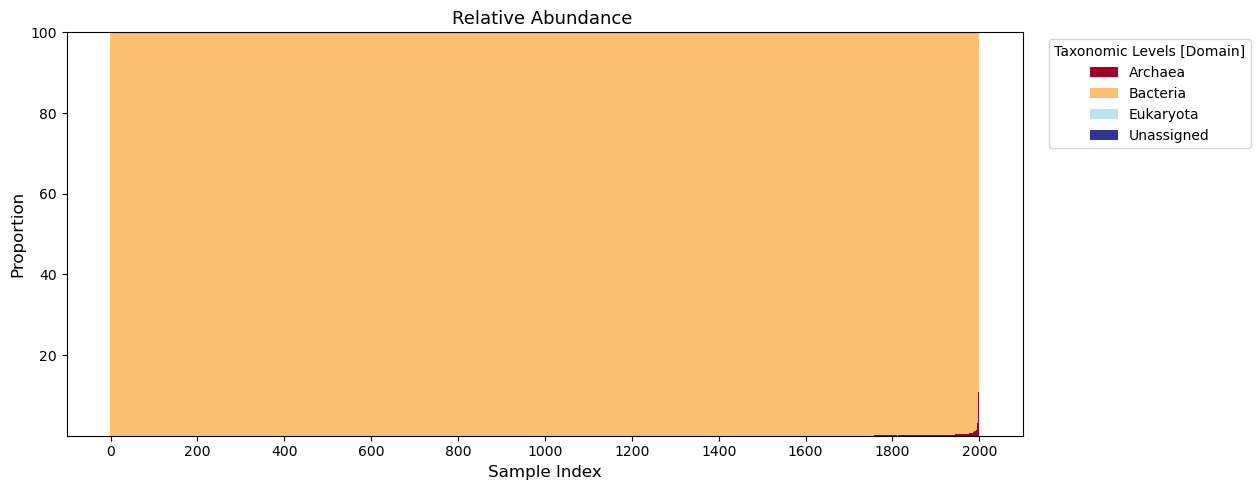

In [67]:
make_stacked_bar_plot(tax_level, df_plot_sorted)

## By Phylum

There are 66 phylums in total.

In [68]:
%%capture
tax_level = 'Phylum'
df_plot_sorted = prepare_plot_dataframe(tax_level, n_taxa=6, n_subset=2000)

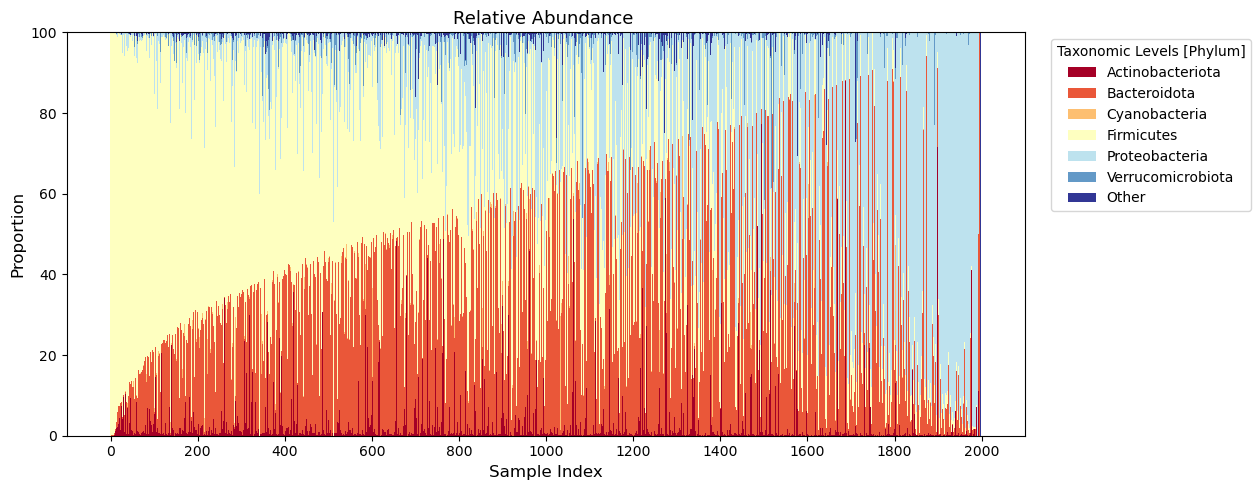

In [69]:
make_stacked_bar_plot(tax_level, df_plot_sorted)

## By Class

In [70]:
%%capture
tax_level = 'Class'
df_plot_sorted = prepare_plot_dataframe(tax_level, n_taxa=6, n_subset=2000)

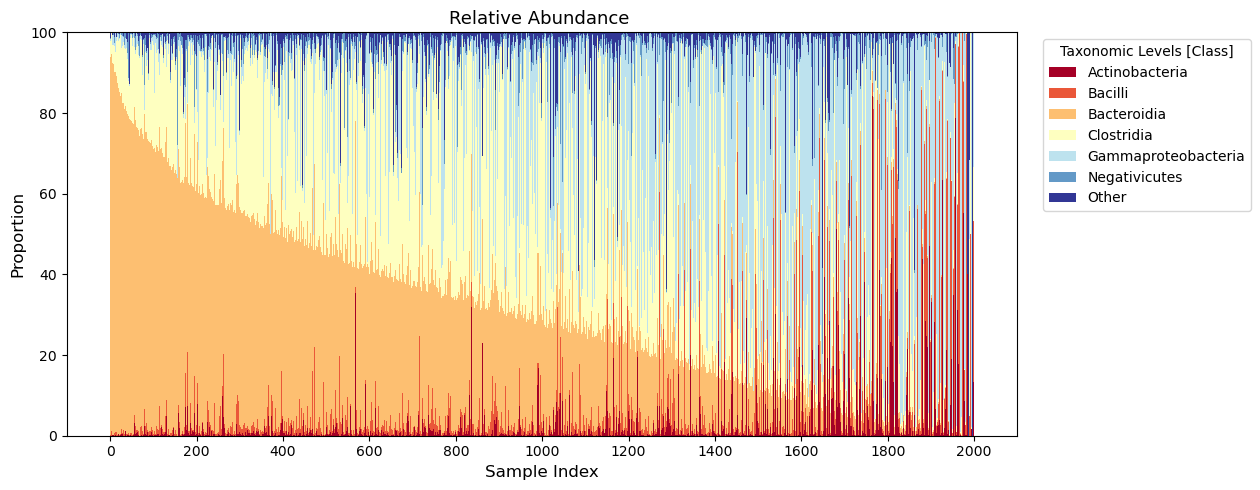

In [71]:
make_stacked_bar_plot(tax_level, df_plot_sorted)

## By Order

In [72]:
%%capture
tax_level = 'Order'
df_plot_sorted = prepare_plot_dataframe(tax_level, n_taxa=10, n_subset=2000)

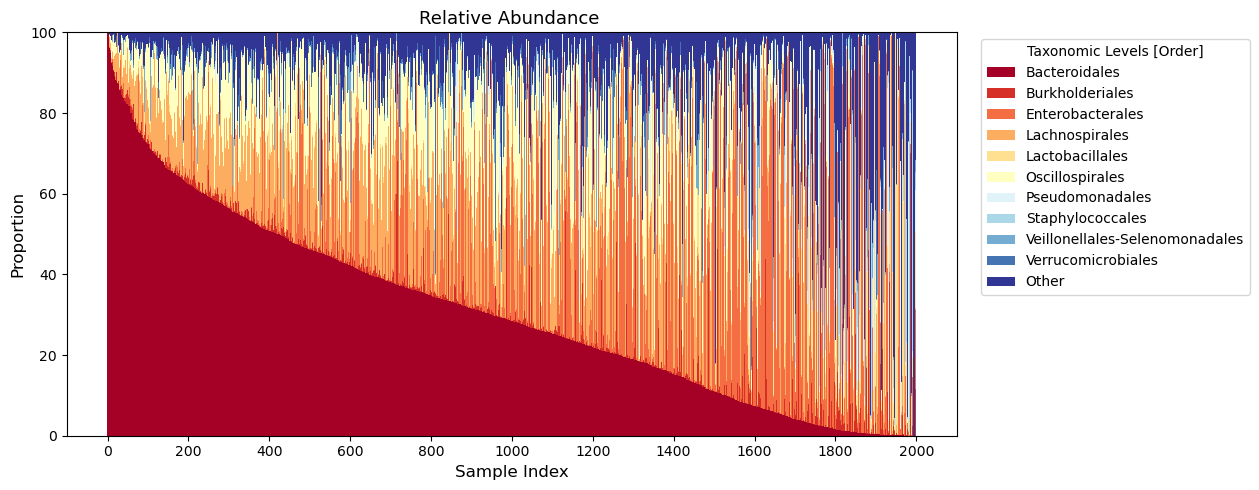

In [73]:
make_stacked_bar_plot(tax_level, df_plot_sorted)

## By Family

In [74]:
%%capture
tax_level = 'Family'
df_plot_sorted = prepare_plot_dataframe(tax_level, n_taxa=10, n_subset=2000)

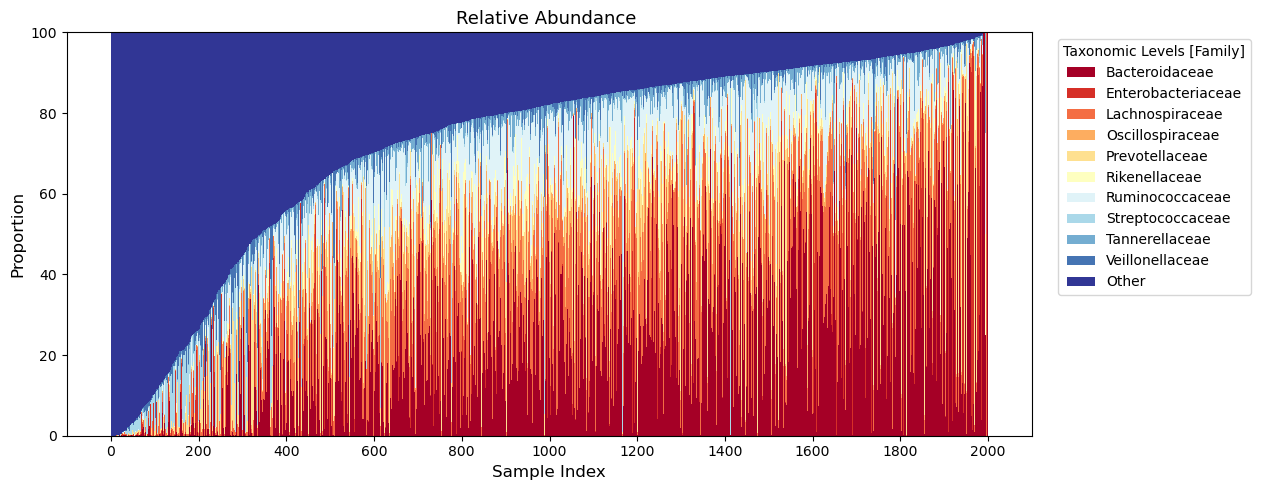

In [75]:
make_stacked_bar_plot(tax_level, df_plot_sorted)

## By Genus

In [76]:
%%capture
tax_level = 'Genus'
df_plot_sorted = prepare_plot_dataframe(tax_level, n_taxa=10, n_subset=2000)

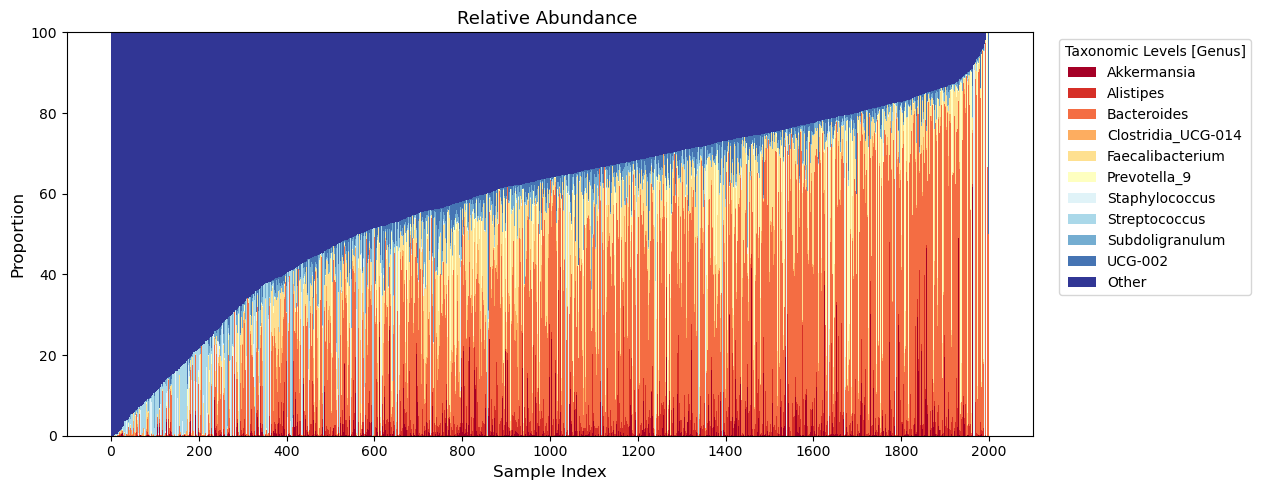

In [77]:
make_stacked_bar_plot(tax_level, df_plot_sorted)